In [6]:
import argparse
import os.path as osp
from datetime import datetime
import json
from collections import defaultdict as dd
from pdb import set_trace as st
import time
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as torch_data
from torch.utils.data import Dataset, DataLoader, Subset
import sys
import  copy
import random
import knockoff.config as cfg
from knockoff import datasets
import knockoff.utils.transforms as transform_utils
import knockoff.utils.model as model_utils
import knockoff.utils.utils as knockoff_utils
import knockoff.models.zoo as zoo

""" Here is the code for verify the acc of GroupCover. Efficiency test is also here. """

    # ----------- Set up dataset


params = {
    'dataset': 'CIFAR100',
   'model_arch':'vgg16_bn',
    'out_path': 'output',
    'pretrained':'imagenet_for_cifar',
    'device_id': 0,
    'batch_size': 64,
    'epochs': 100,
    'lr': 0.1
}

dataset_name = params['dataset']
valid_datasets = datasets.__dict__.keys()
# if dataset_name not in valid_datasets:
#     raise   ValueError('Dataset not found. Valid arguments = {}'.format(valid_datasets))
dataset = datasets.__dict__[dataset_name]
modelfamily = datasets.dataset_to_modelfamily[dataset_name]
train_transform = datasets.modelfamily_to_transforms[modelfamily]['train']
test_transform = datasets.modelfamily_to_transforms[modelfamily]['test']
trainset = dataset(train=True, transform=train_transform)
testset = dataset(train=False, transform=test_transform)
num_classes = len(trainset.classes)
params['num_classes'] = num_classes
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)
if testset is not None:
    test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=10, pin_memory=True)
else:
    test_loader = None


model_name = params['model_arch']
pretrained = params['pretrained']
# model = model_utils.get_net(model_name, n_output_classes=num_classes, pretrained=pretrained)
# pre_model = zoo.get_net(model_name, modelfamily, pretrained, num_classes=num_classes)
# print(pre_model)

checkpoint_path = f'models/victim/{dataset_name}-{model_name}/checkpoint.pth.tar'
model_arch = params['model_arch']

model = zoo.get_net(model_arch, modelfamily, pretrained=pretrained, num_classes=num_classes)
checkpoint = torch.load(checkpoint_path)
epoch = checkpoint['epoch']
best_test_acc = checkpoint['best_acc']
model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint (epoch {}, acc={:.2f})".format(epoch, best_test_acc))



import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
fixed_matrix = np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]], dtype=np.float64)

fixed_co_list = [np.array([1,0,0,0]),np.array([0,1,0,0]),np.array([0,0,1,0]),np.array([0,0,0,1])]
def cluster_vectors(vectors, cluster_size=4):
    index_pairs = np.array([np.array([i]) for i in range(len(vectors))])
    iter = 1
    while(iter<cluster_size):
        iter*=2
        cos_sim_matrix = cosine_similarity(vectors)
        sum_cos_sim_dis = np.mean(cos_sim_matrix, axis=0)
        sorted_indices = np.argsort(sum_cos_sim_dis)[::-1]
        np.fill_diagonal(cos_sim_matrix, np.inf)  
        pairs = []
        index_pair = []
        repeat_index = []
        for i in sorted_indices:
            if i in repeat_index:
                continue
            j = np.argmin(cos_sim_matrix[i])
            repeat_index.append(j)
            cos_sim_matrix[i, :] = np.inf
            cos_sim_matrix[:, i] = np.inf
            cos_sim_matrix[j, :] = np.inf
            cos_sim_matrix[:, j] = np.inf
            index_pair.append(np.concatenate((index_pairs[i], index_pairs[j])))
            pairs.append(np.mean([vectors[i], vectors[j]],axis=0))
        vectors = pairs
        index_pairs = index_pair 
        # print(index_pair) 
    return index_pairs

def modify_conv_layers(original_model, cluster_size=4):
    modified_model = copy.deepcopy(original_model)
    device = torch.device('cuda')
    restore_params = []
    max_attempts = 100
    max_cond_number = 1
    for layer_name, layer in modified_model.named_modules():
        if isinstance(layer, nn.Conv2d):
            print(layer_name)

            with torch.no_grad():
                out_chavicels, in_chavicels, kernel_height, kernel_width = layer.weight.shape
                weights = torch.zeros((out_chavicels,in_chavicels * kernel_height * kernel_width))

                for i in range(out_chavicels):
                    mod_weight = layer.weight[i,:, :, :].view(in_chavicels, -1).flatten()
                    weights[i] = mod_weight
                # print("{:.10e}".format(layer.weight.data[0,1,0,0].item()))

                cluster_index = cluster_vectors(weights.detach().numpy(), cluster_size=cluster_size)
                random_coeff_list = [[] for _ in range(out_chavicels)]
                inv_A_list = []

                for idlist in cluster_index:
                    new_kernels = []
                    A = None

                    # 尝试生成具有较低条件数的矩阵
                    for _ in range(max_attempts):
                        random_coeffs_list = [np.random.rand(cluster_size) for _ in idlist]
                        A = np.array(random_coeffs_list, dtype=np.float64)
                        if np.linalg.cond(A) < max_cond_number:
                            break
                    if A is None or np.linalg.cond(A) >= max_cond_number:
                        A = fixed_matrix
                        random_coeffs_list = fixed_co_list
                    for i, random_coeffs in zip(idlist, random_coeffs_list):
                        random_coeff_list[i] = random_coeffs
                        new_kernel = sum(coeff * layer.weight[idlist[j], :, :, :] for j, coeff in enumerate(random_coeffs))
                        new_kernels.append(new_kernel)
                    for index, idx in enumerate(idlist):
                        layer.weight.data[idx, :, :, :] = new_kernels[index]
                    inv_A = np.linalg.inv(A)
                    inv_A_list.append(torch.tensor(inv_A, dtype=torch.float32))
                # for idlist in cluster_index:
                #     new_kernels = []
                #     for i in idlist:
                #         random_coeffs = np.random.randint(1, 100, size=cluster_size)
                #         random_coeff_list[i] = random_coeffs

                #         new_kernel = sum(coeff * layer.weight[idlist[j], : , :, :] for j, coeff in enumerate(random_coeffs))
                #         new_kernels.append(new_kernel)

                #     for index, idx in enumerate(idlist):
                #         layer.weight.data[idx, :, :, :] = new_kernels[index]
                # for idlist in cluster_index:
                #     A = []
                #     for i in idlist:
                #         A.append(np.array(random_coeff_list[i]))
                #     A = np.array(A, dtype=np.float64)
                #     inv_A = np.linalg.inv(A)
                #     inv_A_list.append(torch.tensor(inv_A,dtype=torch.float64))  
                
                perm = torch.randperm(in_chavicels)
                layer.weight.data = layer.weight.data[ :,perm, :, :]

                restore_params.append(
                    {
                        'shuffle_indices':perm,
                        'cluster_index':cluster_index,
                        'inv_A':inv_A_list
                    }
                )

    return modified_model, restore_params

total = 0
correct = 0
device = torch.device('cuda')
model.to(device)
changed_model.to(device)
with torch.no_grad():
    for _ in range(1):
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = changed_model(inputs)
            # print("-"*20)
            nclasses = outputs.size(1)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            

acc = 100. * correct / total

print('origin acc: [Test]  Epoch: {}\tAcc: {:.1f}% ({}/{})'.format(epoch, acc,
                                                                         correct, total))
modified_model,restore_params = modify_conv_layers(model)

print(modelfamily)
changed_model = zoo.get_net(model_arch, modelfamily, pretrained=pretrained, num_classes=num_classes,restore_params=restore_params)
changed_model.load_state_dict(modified_model.state_dict())

total = 0
correct = 0
device = torch.device('cuda')
model.to(device)
changed_model.to(device)
with torch.no_grad():
    for _ in range(1):
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = changed_model(inputs)
            # print("-"*20)
            nclasses = outputs.size(1)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            

acc = 100. * correct / total

print('Ours: [Test]  Epoch: {}\tAcc: {:.1f}% ({}/{})'.format(epoch, acc,
                                                                         correct, total))

Files already downloaded and verified
Files already downloaded and verified
dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'alexnet', 'vgg', 'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'resnet', 'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'swsl_resnet18', 'ssl_resnet18', 'gluon_resnet18', 'quant_resnet18', 'resnext', 'wresnet', 'math', 'torch', 'nn', 'F', 'BasicBlock', 'NetworkBlock', 'WideResNet', 'wrn_16_1', 'wrn_16_2', 'wrn_40_1', 'wrn_40_2', 'preresnet', 'densenet'])
Total blocks:  14
Forward blocks:  ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40', 'classifier', 'end']
Backward blocks:  ['classifier', 'features.40', 'features.37', 'features.34', 'features.30', 'featu

In [12]:
""" Efficient data process"""


def process_data(file_path):
    conv_times = {'conv0': [], 'conv3': [], 'conv6': [], 'conv8': [], 'conv10': []}

    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line in lines[:-1]:
        conv, time = line.strip().split(' +++ ')
        time = float(time)
        if time <= 10.0:
            conv_times[conv].append(time)

    avg_times = {}
    for conv, times in conv_times.items():
        avg_time = sum(times) / len(times) if times else 0.0
        avg_times[conv] = avg_time

    return avg_times

avg_times = process_data("slalom.txt")
print("slalom Times:")
for conv, time in avg_times.items():
    print(conv, "+++", time)
avg_times = process_data("ourscheme.txt")
print("ourscheme Times:")
for conv, time in avg_times.items():
    print(conv, "+++", time)
avg_times = process_data("darknight.txt")
print("darknight Times:")
for conv, time in avg_times.items():
    print(conv, "+++", time)

slalom Times:
conv0 +++ 3.703393617448586
conv3 +++ 2.82348539983365
conv6 +++ 1.3039578594738923
conv8 +++ 0.9850570485561709
conv10 +++ 0.8108182110363924
ourscheme Times:
conv0 +++ 4.438198574394256
conv3 +++ 3.4467045353148795
conv6 +++ 1.5771957204311708
conv8 +++ 1.1406861896756328
conv10 +++ 1.0012200850474684
darknight Times:
conv0 +++ 4.407581447326031
conv3 +++ 4.13970512778072
conv6 +++ 2.7710751291048727
conv8 +++ 1.6975970769332627
conv10 +++ 1.4815011751853813


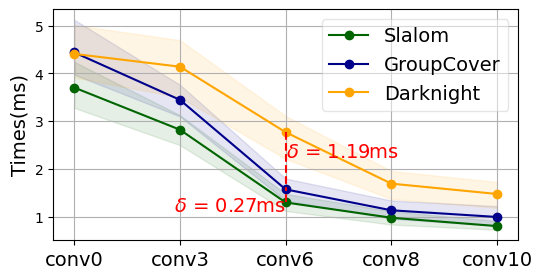

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

def process_data(file_path):
    conv_times = {'conv0': [], 'conv3': [], 'conv6': [], 'conv8': [], 'conv10': []}

    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line in lines[:-1]:
        conv, time = line.strip().split(' +++ ')
        time = float(time)
        if time <= 10.0:  # Assuming we want to filter out times greater than 10.0
            conv_times[conv].append(time)

    stats = {}
    for conv, times in conv_times.items():
        times_array = np.array(times)
        avg_time = np.mean(times_array)
        p90_time = np.percentile(times_array, 90)
        p10_time = np.percentile(times_array, 10)
        stats[conv] = (avg_time, p90_time, p10_time)

    return stats

datasets = ['slalom', 'ourscheme', 'darknight']
all_stats = {}

for dataset in datasets:
    file_path = os.path.join(dataset + '.txt')
    all_stats[dataset] = process_data(file_path)

# Now let's plot the data with shaded areas
conv_layers = ['conv0', 'conv3', 'conv6', 'conv8', 'conv10']
conv_numeric = np.arange(len(conv_layers))

plt.figure(figsize=(6, 3))

colors = {'slalom': 'darkgreen', 'ourscheme': 'darkblue', 'darknight': 'orange'}

for dataset, stats in all_stats.items():
    avg_times = [stats[conv][0] for conv in conv_layers]
    p90_times = [stats[conv][1] for conv in conv_layers]
    p10_times = [stats[conv][2] for conv in conv_layers]
    if dataset=='ourscheme':
        plt.plot(conv_numeric, avg_times, label='GroupCover', marker='o', color=colors[dataset])
        plt.fill_between(conv_numeric, p10_times, p90_times, color=colors[dataset], alpha=0.1)
    else:
        plt.plot(conv_numeric, avg_times, label=dataset.capitalize(), marker='o', color=colors[dataset])
        plt.fill_between(conv_numeric, p10_times, p90_times, color=colors[dataset], alpha=0.1)

data = {
    "Slalom": {
        "conv0": 3.703393617448586,
        "conv3": 2.82348539983365,
        "conv6": 1.3039578594738923,
        "conv8": 0.9850570485561709,
        "conv10": 0.8108182110363924
    },
    "Ourscheme": {
        "conv0": 4.438198574394256,
        "conv3": 3.4467045353148795,
        "conv6": 1.5771957204311708,
        "conv8": 1.1406861896756328,
        "conv10": 1.0012200850474684
    },
    "Darknight": {
        "conv0": 4.407581447326031,
        "conv3": 4.13970512778072,
        "conv6": 2.7710751291048727,
        "conv8": 1.6975970769332627,
        "conv10": 1.4815011751853813
    }
}

conv_index_for_comparison = 2  
delta_ourscheme_slalom = data["Ourscheme"]["conv6"] - data["Slalom"]["conv6"]
delta_ourscheme_darknight =data["Darknight"]["conv6"] -  data["Ourscheme"]["conv6"] 

plt.plot([conv_index_for_comparison, conv_index_for_comparison], [data["Slalom"]["conv6"], data["Ourscheme"]["conv6"]], 'r--')
plt.text(conv_index_for_comparison, (data["Slalom"]["conv6"] + data["Ourscheme"]["conv6"]) / 2, f'$\delta$ = {delta_ourscheme_slalom:.2f}ms', color='red', ha='right', va='top',fontsize = 14)

plt.plot([conv_index_for_comparison, conv_index_for_comparison], [data["Darknight"]["conv6"], data["Ourscheme"]["conv6"]], 'r--')
plt.text(conv_index_for_comparison, (data["Darknight"]["conv6"] + data["Ourscheme"]["conv6"]) / 2, f'$\delta$ = {delta_ourscheme_darknight:.2f}ms', color='red', ha='left', va='bottom',fontsize = 14)



plt.ylabel('Times(ms)',fontsize = 14)
plt.xticks(conv_numeric, conv_layers,fontsize = 14)  

plt.legend(loc='upper right', bbox_to_anchor=(1,1), framealpha=0.5,fontsize = 14)

# Show the plot with a grid
plt.grid(True)
plt.savefig('eff.pdf')
plt.show()


In [ ]:


""" Here is the code to get the acc of obfuscated model and secret model """



    # ----------- Set up dataset
  
model_names = ['alexnet','resnet18','resnet50','vgg16_bn']
dataset_names = ['CIFAR10','CIFAR100','STL10']

for model_name in model_names:
    for dataset_name in dataset_names:
        nnsplitter_path = (f'models/nnsplitter/{dataset_name}-{model_name}-nnsplitter.pth')
        modified_dict = torch.load(nnsplitter_path)
        print('-'*20,nnsplitter_path,modified_dict['best_acc'])

        # soter_path = (f'models/soter/{dataset_name}-{model_name}-soter.pth')
        # modified_dict = torch.load(soter_path)
        # print('-'*20,soter_path,modified_dict['best_acc']/100)

        # shadownet_path = (f'models/shadownet/{dataset_name}-{model_name}-shadownet.pth')
        # modified_dict = torch.load(shadownet_path)
        # print('-'*20,shadownet_path,modified_dict['best_acc']/100)

        # magnitude_path = (f'models/magnitude/{dataset_name}-{model_name}-magnitude.pth')
        # modified_dict = torch.load(magnitude_path)
        # print('-'*20,magnitude_path,modified_dict['best_acc']/100)

        # ourscheme_path = (f'models/ourscheme/{dataset_name}-{model_name}.pth')
        # modified_dict = torch.load(ourscheme_path)
        # print('-'*20,ourscheme_path,modified_dict['best_acc']/100)

        # victim_path = (f'models/victim/{dataset_name}-{model_name}/checkpoint.pth.tar')
        # modified_dict = torch.load(victim_path)
        # print('-'*20,victim_path,modified_dict['best_acc']/100)


In [ ]:

""" Find the min CV in each small interval. """


import math
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde, chisquare


def get_model_parameters(model):

    return [p.data.cpu().numpy() for p in model.parameters()]


def calculate_coefficient_of_variation(data):

    if len(data) <= 1:
        return np.nan  
    mean = np.mean(data)
    std = np.std(data)
    if mean == 0:
        return np.nan  
    cv = std / abs(mean)  
    return cv  


def coefficient_of_variation_analysis_with_lowest_cv(model):
    params = get_model_parameters(model)
    all_values = np.concatenate([p.flatten() for p in params])

    min_val, max_val = np.min(all_values), np.max(all_values)
    range_val = max_val - min_val

    interval_size = 0.001 * range_val
    intervals = np.arange(min_val, max_val, interval_size)
    cvs = []

    for i in range(len(intervals) - 1):
        lower_bound = intervals[i]
        upper_bound = intervals[i + 1]
        
        interval_values = all_values[(all_values >= lower_bound) & (all_values < upper_bound)]
        if len(interval_values) >= 100:  
            cv = calculate_coefficient_of_variation(interval_values)
            cvs.append((lower_bound, upper_bound, cv))
    min_cv_interval = min(cvs, key=lambda x: x[2])

    return min_cv_interval 

  
model_names = ['alexnet','resnet18','resnet50','vgg16_bn']
dataset_names = ['CIFAR10','CIFAR100','STL10']
# model_names = [ 'vgg16_bn']
# dataset_names = ['CIFAR10']
results = []
for model_name in model_names:
    for dataset_name in dataset_names:
     

        victim_path = (f'models/victim/{dataset_name}-{model_name}/checkpoint.pth.tar')
        modified_dict = torch.load(victim_path)
        print('-'*20,victim_path,modified_dict['best_acc']/100)

        valid_datasets = datasets.__dict__.keys()
        dataset = datasets.__dict__[dataset_name]
        modelfamily = datasets.dataset_to_modelfamily[dataset_name]
        train_transform = datasets.modelfamily_to_transforms[modelfamily]['train']
        test_transform = datasets.modelfamily_to_transforms[modelfamily]['test']
        trainset = dataset(train=True, transform=train_transform)
        testset = dataset(train=False, transform=test_transform)
        num_classes = len(trainset.classes)
        train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)
        if testset is not None:
            test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=10, pin_memory=True)
        else:
            test_loader = None
        
        if dataset_name == "STL10":
            pretrained = "imagenet"
        else:
            pretrained = "imagenet_for_cifar"


        model = zoo.get_net(model_name, modelfamily, pretrained=pretrained, num_classes=num_classes)
        model.load_state_dict(modified_dict['state_dict'])


        interval = coefficient_of_variation_analysis_with_lowest_cv(model)
        print(f"{dataset_name}-{model_name}-Interval: {interval[0]} to {interval[1]}, CV: {interval[2]}")
        results.append({
                'model_name': model_name,
                'dataset_name': dataset_name,
                'cv_ratio': interval[2]
            })

np.save('victimCV.npy',results)




[{'model_name': 'alexnet', 'dataset_name': 'CIFAR10', 'cv_ratio': 0.0055681365}
 {'model_name': 'alexnet', 'dataset_name': 'CIFAR100', 'cv_ratio': 0.0043847966}
 {'model_name': 'alexnet', 'dataset_name': 'STL10', 'cv_ratio': 0.005884978}
 {'model_name': 'resnet18', 'dataset_name': 'CIFAR10', 'cv_ratio': 0.0031940222}
 {'model_name': 'resnet18', 'dataset_name': 'CIFAR100', 'cv_ratio': 0.002578348}
 {'model_name': 'resnet18', 'dataset_name': 'STL10', 'cv_ratio': 0.0031930257}
 {'model_name': 'resnet50', 'dataset_name': 'CIFAR10', 'cv_ratio': 0.0017722074}
 {'model_name': 'resnet50', 'dataset_name': 'CIFAR100', 'cv_ratio': 0.0017860181}
 {'model_name': 'resnet50', 'dataset_name': 'STL10', 'cv_ratio': 0.002191474}
 {'model_name': 'vgg16_bn', 'dataset_name': 'CIFAR10', 'cv_ratio': 0.0046842415}
 {'model_name': 'vgg16_bn', 'dataset_name': 'CIFAR100', 'cv_ratio': 0.003509188}
 {'model_name': 'vgg16_bn', 'dataset_name': 'STL10', 'cv_ratio': 0.0032288255}]


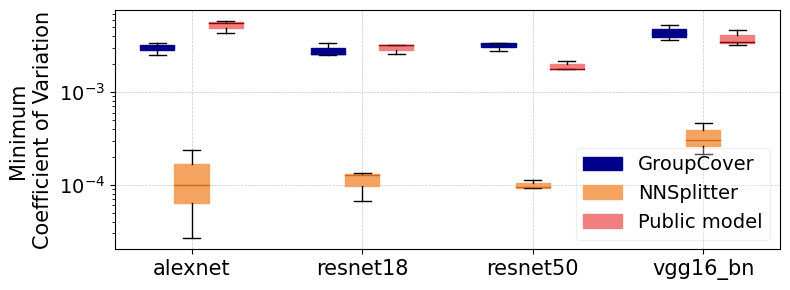

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from operator import itemgetter
from matplotlib.ticker import LogFormatter
import os
import matplotlib.patches as mpatches

our_results = np.load('ourCV.npy', allow_pickle=True)
nn_results = np.load('nnsplitterCV.npy', allow_pickle=True)
vic_results = np.load('victimCV.npy', allow_pickle=True)
print(vic_results)

def group_data_for_boxplot(results):
    sorted_results = sorted(results, key=lambda x: (x['model_name'], x['dataset_name']))
    grouped_by_model = groupby(sorted_results, key=itemgetter('model_name'))
    
    cv_ratios_by_model_dataset = {}
    for model_name, model_group in grouped_by_model:
        grouped_by_dataset = groupby(model_group, key=itemgetter('dataset_name'))
        cv_ratios_by_model_dataset[model_name] = {dataset_name: [result['cv_ratio'] for result in dataset_group]
                                                  for dataset_name, dataset_group in grouped_by_dataset}
    return cv_ratios_by_model_dataset

plt.figure(figsize=(8,3))
our_data_grouped = group_data_for_boxplot(our_results)
nn_data_grouped = group_data_for_boxplot(nn_results)
vic_data_grouped = group_data_for_boxplot(vic_results)

model_names = sorted(set(result['model_name'] for result in our_results))

positions = np.arange(len(model_names)) * 2.0  # Spacing between groups

def prepare_data_for_boxplot(data_grouped):
    data_for_boxplot = []
    for model_name in model_names:
        cv_ratios = [cv for dataset in data_grouped[model_name].values() for cv in dataset]
        data_for_boxplot.append(cv_ratios)
    return data_for_boxplot

our_data_for_boxplot = prepare_data_for_boxplot(our_data_grouped)
nn_data_for_boxplot = prepare_data_for_boxplot(nn_data_grouped)
vic_data_for_boxplot = prepare_data_for_boxplot(vic_data_grouped)

box_width = 0.4
plt.boxplot(our_data_for_boxplot, positions=positions - box_width, widths=box_width,
            patch_artist=True, boxprops=dict(facecolor='darkblue', color='darkblue'),
            medianprops=dict(color='navy'))
plt.boxplot(nn_data_for_boxplot, positions=positions, widths=box_width,
            patch_artist=True, boxprops=dict(facecolor='sandybrown', color='sandybrown'),
            medianprops=dict(color='chocolate'))
plt.boxplot(vic_data_for_boxplot, positions=positions + box_width, widths=box_width,
            patch_artist=True, boxprops=dict(facecolor='lightcoral', color='lightcoral'),
            medianprops=dict(color='darkred'))

plt.yscale('log')
our_patch = mpatches.Patch(color='darkblue', label='GroupCover')
nn_patch = mpatches.Patch(color='sandybrown', label='NNSplitter')
vic_patch = mpatches.Patch(color='lightcoral', label='Public model')
plt.legend(handles=[our_patch, nn_patch, vic_patch], loc='lower right', frameon=True, framealpha=0.3,fancybox=True, fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# plt.legend(['Our model', 'NNSplitter', 'VIC model'], loc='lower', frameon=True, fancybox=True, fontsize=14)
plt.ylabel('Minimum \nCoefficient of Variation', fontsize=15)
plt.xticks(positions, model_names, ha='center', fontsize=15)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('cvxiangtu.pdf')

plt.show()


In [ ]:
""" Find the similarity match rate between obfuscated model and public pre-trained model """

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np



def cluster_vectors(vectors, cluster_size=4):
    index_pairs = np.array([np.array([i]) for i in range(len(vectors))])
    iter = 1
    while(iter<cluster_size):
        iter*=2
        cos_sim_matrix = cosine_similarity(vectors)
        sum_cos_sim_dis = np.mean(cos_sim_matrix, axis=0)
        sorted_indices = np.argsort(sum_cos_sim_dis)[::-1]
        np.fill_diagonal(cos_sim_matrix, np.inf)  
        pairs = []
        index_pair = []
        repeat_index = []
        for i in sorted_indices:
            if i in repeat_index:
                continue
            j = np.argmin(cos_sim_matrix[i])
            repeat_index.append(j)
            cos_sim_matrix[i, :] = np.inf
            cos_sim_matrix[:, i] = np.inf
            cos_sim_matrix[j, :] = np.inf
            cos_sim_matrix[:, j] = np.inf
            index_pair.append(np.concatenate((index_pairs[i], index_pairs[j])))
            pairs.append(np.mean([vectors[i], vectors[j]],axis=0))
        vectors = pairs
        index_pairs = index_pair 
        # print(index_pair) 
    return index_pairs

def modify_conv_layers(original_model, cluster_size=4):
    modified_model = copy.deepcopy(original_model)
    device = torch.device('cuda')
    restore_params = {}
    
    for layer_name, layer in modified_model.named_modules():
        if isinstance(layer, nn.Conv2d):
            print(layer_name)

            with torch.no_grad():
                out_channels, in_channels, kernel_height, kernel_width = layer.weight.shape
                weights = torch.zeros((out_channels,in_channels * kernel_height * kernel_width))

                for i in range(out_channels):
                    mod_weight = layer.weight[i,:, :, :].view(in_channels, -1).flatten()
                    weights[i] = mod_weight
                # print("{:.10e}".format(layer.weight.data[0,1,0,0].item()))

                cluster_index = cluster_vectors(weights.detach().numpy(), cluster_size=cluster_size)
                random_coeff_list = [[] for _ in range(out_channels)]
                inv_A_list = []
                for idlist in cluster_index:
                    new_kernels = []
                    for i in idlist:
                        random_coeffs = np.random.randint(1, 100, size=cluster_size)
                        random_coeff_list[i] = random_coeffs

                        new_kernel = sum(coeff * layer.weight[idlist[j], : , :, :] for j, coeff in enumerate(random_coeffs))
                        new_kernels.append(new_kernel)

                    for index, idx in enumerate(idlist):
                        layer.weight.data[idx, :, :, :] = new_kernels[index]
                for idlist in cluster_index:
                    A = []
                    for i in idlist:
                        A.append(np.array(random_coeff_list[i]))
                    A = np.array(A, dtype=np.float64)
                    inv_A = np.linalg.inv(A)
                    inv_A_list.append(torch.tensor(inv_A,dtype=torch.float32))  
                
                # perm = torch.randperm(in_channels)
                # layer.weight.data = layer.weight.data[ :,perm, :, :]

                restore_params[layer_name] = {
                        # 'shuffle_indices':perm,
                        'cluster_index':cluster_index,
                        'inv_A':inv_A_list
                    }
                

    return modified_model, restore_params


def find_max_similarity(pre_model, modified_model):
    pre_model = pre_model.cuda()
    modified_model = modified_model.cuda()
    res = []
    count_same_index = 0
    total_count = 0

    for layer_name, pre_layer in pre_model.named_modules():
        if isinstance(pre_layer, nn.Conv2d):
            mod_layer = dict(modified_model.named_modules())[layer_name]
            assert pre_layer.weight.shape == mod_layer.weight.shape

            out_channels, in_channels, kernel_height, kernel_width = pre_layer.weight.shape
            if out_channels % 2 != 0:
                continue

            pre_weights = pre_layer.weight.view(out_channels, -1).cuda()
            mod_weights = mod_layer.weight.view(out_channels, -1).cuda()

            # Calculate the cosine similarity matrix between the flattened weights
            similarity_matrix = cosine_similarity(
                pre_weights.cpu().detach().numpy(),
                mod_weights.cpu().detach().numpy()
            )

            # Find the index of the max similarity for each kernel in pre_model
            max_indices = np.argmax(similarity_matrix, axis=1)
            
            # Check if the max similarity is with the kernel of the same index
            count_same_index = np.sum(max_indices == np.arange(out_channels))
            res.append(count_same_index/out_channels)
    return res


model_names = ['alexnet','resnet18','resnet50','vgg16_bn']
dataset_names = ['CIFAR10','CIFAR100','STL10']
# model_names = [ 'resnet50','vgg16_bn']
# dataset_names = ['CIFAR100']
results = []
for model_name in model_names:
    for dataset_name in dataset_names:
        # nnsplitter_path = (f'models/nnsplitter/{dataset_name}-{model_name}-nnsplitter.pth')
        # modified_dict = torch.load(nnsplitter_path)
        # print('-'*20,nnsplitter_path,modified_dict['best_acc'])

        # magnitude_path = (f'models/magnitude/{dataset_name}-{model_name}-magnitude.pth')
        # modified_dict = torch.load(magnitude_path)
        # print('-'*20,magnitude_path,modified_dict['best_acc']/100)

        # ourscheme_path = (f'models/ourscheme/{dataset_name}-{model_name}.pth')
        # modified_dict = torch.load(ourscheme_path)
        # print('-'*20,ourscheme_path,modified_dict['best_acc']/100)

        victim_path = (f'models/victim/{dataset_name}-{model_name}/checkpoint.pth.tar')
        modified_dict = torch.load(victim_path)
        print('-'*20,victim_path,modified_dict['best_acc']/100)

        valid_datasets = datasets.__dict__.keys()
        dataset = datasets.__dict__[dataset_name]
        modelfamily = datasets.dataset_to_modelfamily[dataset_name]
        train_transform = datasets.modelfamily_to_transforms[modelfamily]['train']
        test_transform = datasets.modelfamily_to_transforms[modelfamily]['test']
        trainset = dataset(train=True, transform=train_transform)
        testset = dataset(train=False, transform=test_transform)
        num_classes = len(trainset.classes)
        train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)
        if testset is not None:
            test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=10, pin_memory=True)
        else:
            test_loader = None
        
        if dataset_name == "STL10":
            pretrained = "imagenet"
        else:
            pretrained = "imagenet_for_cifar"
        # model = model_utils.get_net(model_name, n_output_classes=num_classes, pretrained=pretrained)
        pre_model = zoo.get_net(model_name, modelfamily, pretrained, num_classes=num_classes)
        # print(pre_model)

        model = zoo.get_net(model_name, modelfamily, pretrained=pretrained, num_classes=num_classes)
        model.load_state_dict(modified_dict['state_dict'])
        res = find_max_similarity(pre_model,model)
        # modified_model,restore_params = modify_conv_layers(model)
#         positive_rate,random_rate = find_max_similarity(pre_model,modified_model,restore_params)
        result = {
            'model_name':model_name,
            'dataset_name':dataset_name,
            'positive_rate' :res,
            # 'random_rate':random_rate
        }
        results.append(result)
np.save('otherPR.npy',results)










/tmp/ipykernel_1596657/2574850505.py:76: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1, 11), random_upper_bound, 'r', color='red',linewidth=2,label = 'Randomly Guess')


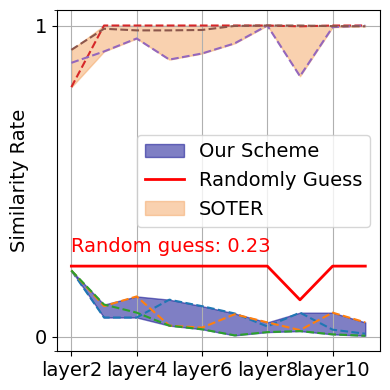

In [48]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from operator import itemgetter
from matplotlib.ticker import LogFormatter
import os
import matplotlib.patches as mpatches


ourPR = np.load('ourPR.npy',allow_pickle=True)
otherPR = np.load('otherPR.npy',allow_pickle=True)

ourPR = [item for item in ourPR if item['model_name'] != 'alexnet']
otherPR = [item for item in otherPR if item['model_name'] != 'alexnet']



model_names = sorted(set(item['model_name'] for item in ourPR))

data = {model: {'positive_rate': [], 'random_rate': []} for model in model_names}

for model in model_names:
    model_data = [item for item in ourPR if item['model_name'] == model]
    for rate_type in ['positive_rate', 'random_rate']:
        rates_first_ten = [data[rate_type][:10] for data in model_data]
        data[model][rate_type] = np.mean(rates_first_ten, axis=0)

positive_rates = [data[model]['positive_rate'] for model in model_names]
random_rates = [data[model]['random_rate'] for model in model_names]

positive_upper_bound = np.nanmax(positive_rates, axis=0)
positive_lower_bound = np.nanmin(positive_rates, axis=0)
random_upper_bound = np.nanmax(random_rates, axis=0)
random_lower_bound = np.nanmin(random_rates, axis=0)

for model in model_names:
    model_data = [item for item in otherPR if item['model_name'] == model]
    for rate_type in ['positive_rate']:
        rates_first_ten = [data[rate_type][:10] for data in model_data]
        data[model][rate_type] = np.sum(rates_first_ten, axis=0) / len(rates_first_ten)

other_positive_rates = [data[model]['positive_rate'] for model in model_names]

other_positive_upper_bound = np.nanmax(other_positive_rates, axis=0)
other_positive_lower_bound = np.nanmin(other_positive_rates, axis=0)
plt.figure(figsize=(8, 4))

for i, model in enumerate(model_names):
    plt.plot(range(1, 11), positive_rates[i], linestyle='--')

plt.fill_between(range(1, 11), positive_lower_bound, positive_upper_bound, alpha=0.5, color='darkblue', label='Our Scheme')

plt.plot(range(1, 11), random_upper_bound, 'r', color='red',linewidth=2,label = 'Randomly Guess')
plt.annotate(f'Random guess: {random_upper_bound[0]:.2f}', (1, random_upper_bound[0]), textcoords='offset points', xytext=(0,10), ha='left', color='red',fontsize = 14)


for i, model in enumerate(model_names):
    plt.plot(range(1, 11), other_positive_rates[i], linestyle='--')

plt.fill_between(range(1, 11), other_positive_lower_bound, other_positive_upper_bound, alpha=0.5, color='sandybrown', label='SOTER')

plt.yscale('symlog')
y_major_locator = MultipleLocator(1)
y_major_formatter = FormatStrFormatter('%d')
plt.gca().yaxis.set_major_locator(y_major_locator)
plt.gca().yaxis.set_major_formatter(y_major_formatter)

plt.ylabel('Similarity Rate',fontsize=14)
layer_labels = [ 'layer2', 'layer4',  'layer6', 'layer8', 'layer10']
plt.xticks(range(1, 11,2), layer_labels, fontsize=14) 
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.grid(True)
plt.legend(fontsize=14,loc='center right',ncol=1)
plt.tight_layout()

plt.savefig('pr.pdf')
plt.show()

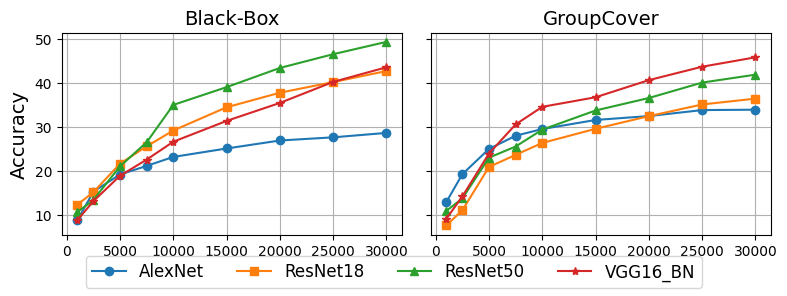

In [9]:
import matplotlib.pyplot as plt

budgets = [1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000]

alexnet_adv = [8.79, 15.27, 19.18, 21.14, 23.18, 25.10, 26.92, 27.64, 28.65]
resnet18_adv = [12.33, 15.15, 21.63, 25.59, 29.19, 34.48, 37.79, 40.22, 42.73]
resnet50_adv = [10.62, 13.40, 21.05, 26.51, 35.02, 39.06, 43.43, 46.56, 49.37]
vgg16_bn_adv = [8.8, 13.1, 18.89, 22.57, 26.64, 31.38, 35.47, 40.26, 43.59]

alexnet_our = [12.91, 19.25, 25.00, 28.0, 29.53, 31.59, 32.48, 33.84, 33.93]
resnet18_our = [7.59, 11.04, 20.89, 23.66, 26.36, 29.58, 32.46, 35.12, 36.45]
resnet50_our = [10.90, 13.72, 23.01, 25.55, 29.39, 33.75, 36.59, 40.10, 41.90]
vgg16_bn_our = [9.12, 14.18, 23.95, 30.58, 34.58, 36.76, 40.66, 43.71, 45.85]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

ax1.plot(budgets, alexnet_adv, marker='o', label='AlexNet')
ax1.plot(budgets, resnet18_adv, marker='s', label='ResNet18')
ax1.plot(budgets, resnet50_adv, marker='^', label='ResNet50')
ax1.plot(budgets, vgg16_bn_adv, marker='*', label='VGG16_BN')
ax1.set_title('Black-Box',fontsize = 14)
ax1.set_ylabel('Accuracy',fontsize = 14)
ax1.grid(True)

ax2.plot(budgets, alexnet_our, marker='o', label='AlexNet')
ax2.plot(budgets, resnet18_our, marker='s', label='ResNet18')
ax2.plot(budgets, resnet50_our, marker='^', label='ResNet50')
ax2.plot(budgets, vgg16_bn_our, marker='*', label='VGG16_BN')
ax2.set_title('GroupCover',fontsize = 14)
ax2.grid(True)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4,fontsize = 12)

fig.tight_layout(rect=[0, 0.07, 1, 1])


plt.savefig('varBudget.pdf')
plt.show()